In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 设置matplotlib正常显示中文和负号
# matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
# matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号

## 计算最优案例数 

In [2]:
def concat_hh(filename, baseline="heuristic", noExcat=True):
	h = pd.read_csv(f"../result/{baseline}.csv")
	if noExcat:
		h = h[h['method'] != 'excat']
	hh = pd.read_csv(f"result/{filename}.csv")
	hh['method'] = "RLHH"
	df = pd.concat([h, hh])
	return df

In [3]:
def count(df):
	df_count = df[['No.', 'method', 'type']].groupby(['type', 'method'], as_index=False).count()
	df_count = df_count.pivot('type', 'method', 'No.')
	df_count.fillna(0, inplace=True)

	df_count['sum'] = df_count.sum(axis=1)
	df_count.loc['sum'] = df_count.sum(axis=0)
	df_count = df_count.astype(int)

	return df_count

In [11]:
def preprocess(df):
    df = df[df['method'] != 'excat']
    df['objval'] = df['objval'].apply(lambda x: round(x, 2))
    df['time'] = df['time'].apply(lambda x: round(x, 2))
    if "type" not in df.columns:
        df["type"] = df['instance'].map(lambda x: x[:-2])
    return df

### 有RLHH

In [20]:
filename = "test_small_MLP_entropy_21.14-11.03"
df = concat_hh(filename, baseline="large_instances", noExcat=True)

### 没有RLHH


In [ ]:
filename = "all_instances"
df = pd.read_csv(f"result/{filename}.csv")

In [21]:
df = preprocess(df)
# 先比最优值，再比速度
df_best_fast = df.sort_values(by=['driver', 'time'], ascending=True)
df_best_fast = df_best_fast.groupby(['No.']).head(1)
best_fast_count = count(df_best_fast)

# 最优值比较
df_best = df.groupby('No.').apply(lambda t: t[t.objval==t.objval.min()]).reset_index(drop=True)
best_count = count(df_best)
best_count['sum'] = best_fast_count['sum']

# 速度比较
df_fast = df.groupby('No.').apply(lambda t: t[t.time == t.time.min()]).reset_index(drop=True)
fast_count = count(df_fast)

In [22]:
best_fast_count

method,BestEdges1,BestEdges2,BestEdges3,BestNodes,BestPaths,Hyper,RLHH,sum
type,,,,,,,,
c2,3,4,2,2,1,0,5,17
r2,5,9,0,2,0,1,0,17
rc2,0,8,0,0,3,4,1,16
sum,8,21,2,4,4,5,6,50


In [23]:
best_count

method,BestEdges1,BestEdges2,BestEdges3,BestNodes,BestPaths,Hyper,RLHH,sum
type,,,,,,,,
c2,10,9,6,8,8,0,8,17
r2,5,9,0,3,0,1,1,17
rc2,0,8,0,0,3,4,1,16
sum,15,26,6,11,11,5,10,50


In [24]:
best_fast_sum = best_fast_count.loc["sum", "RLHH"]
best_sum = best_count.loc["sum", "RLHH"]
with pd.ExcelWriter(f"result/count_{best_fast_sum}_{best_sum}_{filename}.xlsx") as writer:
    best_fast_count.T.to_excel(writer, sheet_name="best_fast")
    best_count.T.to_excel(writer, sheet_name="best")
    fast_count.T.to_excel(writer, sheet_name="fast")

In [14]:
fast_count

13

In [ ]:
print(best_fast_count.T.to_latex())

In [ ]:
print(best_count.T.to_latex())

### 详细数据对比

In [69]:
h = pd.read_csv("result/heuristic.csv")
rl = pd.read_csv("result/test_small_MLP_entropy_17.19-11.04.csv")
h = preprocess(h)
rl = preprocess(rl)
h = h[h["type"] == "r2"]
index = h.loc[h["method"] == "BestEdges1", ["instance", "n"]].values
h1 = h.loc[h["method"] == "BestEdges1", ["objval", "time"]].values
h2 = h.loc[h["method"] == "BestEdges2", ["objval", "time"]].values
h3 = h.loc[h["method"] == "BestEdges3", ["objval", "time"]].values
h4 = h.loc[h["method"] == "BestNodes", ["objval", "time"]].values
h5 = h.loc[h["method"] == "BestPaths", ["objval", "time"]].values
hh = h.loc[h["method"] == "Hyper", ["objval", "time"]].values
rl = rl.loc[rl["type"] == "r2", ["objval", "time"]].values

d:\ruanjian\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
d:\ruanjian\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
d:\ruanjian\Anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [75]:
df = pd.DataFrame(
    np.concatenate([index, h1, h2, h3, h4, h5, hh, rl], axis=1), 
    columns=[['case', 'method', 'h1', 'h1', 'h2', 'h2', 'h3', 'h3', 'h4', 'h4', 'h5', 'h5', 'hh', 'hh', 'rl', 'rl'], ["instance", "n"] + ["obj", "time"]*7])
# [i for item in [[f"h{i}"]*2 for i in range(1,6)] for i in item]
df

case method       h1               h2               h3          \
   instance      n      obj    time      obj    time      obj    time   
0      r203     25   669.77   12.45   669.04   58.11    768.3   67.23   
1      r202     30   440.98   12.95   522.45   64.56   509.47   14.42   
2      r201     27   520.28    4.76   506.05    5.42   506.71    6.82   
3      r209     31   715.36   12.12   788.04   21.63   858.35   80.76   
4      r208     28  1291.17  599.52  1113.49  539.96  1291.17  599.49   
5      r204     32  1504.75  599.51   1221.9   31.13  1504.75  599.44   
6      r202     25   559.35     6.1   499.75   11.13   550.35   12.03   
7      r211     34  1151.35  161.44  1210.89    69.9  1626.38  599.42   
8      r209     25   821.21    4.76   739.32   16.45  1121.88   47.08   
9      r208     28  1291.17  599.51  1113.49  536.33  1291.17  599.49   
10     r202     27   490.71    9.25   463.77   21.96   577.41    9.01   
11     r210     28   786.53   11.38   660.88   34.17   903.06   16.56   
12     r211     26  1018.51   92.42  1085.38  157.85  1268.52  599.52   
13     r202     28   534.73   10.32   543.75   45.73   537.56   12.55   
14     r209     26   627.79     7.1   766.72   10.19   723.77    49.9   
15     r210     28   786.53   11.29   660.88      34   903.06   16.11   
16     r201     32    583.4     6.8   545.18      12   573.84    8.12   

         h4               h5               hh               rl         
        obj    time      obj    time      obj    time      obj   time  
0       689   79.19   714.12  255.53   724.06  123.23   520.25  45.71  
1    516.33   44.53   639.64   62.31   460.19   11.85   480.86  28.15  
2    506.05    8.24   507.69   11.04   559.04    6.62   504.17   7.31  
3    820.94   31.71  1160.49  132.34   877.18   39.53   819.72   7.39  
4   1291.17  599.51  1232.41  599.48  1155.43  381.84  1200.78   3.85  
5   1504.75  599.46  1408.62  599.45  1469.72  599.45  1139.31   7.85  
6    543.28   22.43   552.21   29.45  1022.81   10.44   496.58  12.88  
7   1352.74  326.43  1488.33  599.41  1591.35  599.47  1467.85   6.65  
8    917.29   12.28   868.09   63.44   809.54       5   643.02   6.91  
9   1291.17  599.51  1232.41   599.5  1256.13  599.49  1200.78   3.87  
10   549.26   34.08   684.89   52.57   991.85   27.22   533.66  13.71  
11   847.16   40.39   775.87   74.91   648.06    9.12   677.92   4.83  
12  1253.23  129.05  1148.47  242.37  1241.78   98.32  1007.23   2.09  
13   468.72   53.38   526.55   52.71   968.57    6.96   456.28  29.68  
14   760.53      14   747.84   75.88  1201.03    4.56   784.66   8.94  
15   845.52   22.91   775.87   74.02   890.44    5.81   677.92   4.79  
16   545.12   14.94   564.58   22.84   563.13    7.32   561.28  10.55

In [76]:
df.to_csv("result/result_xiangxi.csv", index=False)

## 读取tensorboard数据-test

In [ ]:
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 设置matplotlib正常显示中文和负号
# matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
# matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
 
#加载日志数据
ea=event_accumulator.EventAccumulator('test/tensorboard_logs/a=100_e=0.05_g=0.99_lr=0.1_seed=123_15.51-10.27') 
ea.Reload()
print(ea.scalars.Keys())

In [ ]:
objval = [i.value for i in ea.scalars.Items('3_objval')]
n_step = len(objval)

In [ ]:
plt.figure()
plt.plot(range(n_step), objval, 'r', label='RLHH')
plt.plot(range(n_step), [1333.19]*n_step, label='BestEdges1')
plt.plot(range(n_step), [750.4326]*n_step, label='BestEdges2')
plt.plot(range(n_step), [924.8947]*n_step, label='BestPaths')
plt.plot(range(n_step), [635.1466]*n_step, label='Hyper')
plt.legend(loc="upper right")
plt.xlabel("episode")
plt.ylabel("objval")
# plt.savefig("F:/Users/Documents/汇报/img/test_r201.png")
plt.show()

In [ ]:
gap = [i.value for i in ea.scalars.Items('3_gap')]

In [ ]:
min(gap)

In [ ]:
max(objval)

smooth

In [ ]:
avg_obj = [sum(objval[:i]) / i for i in range(1,n_step+1)]

In [ ]:
plt.figure()
plt.plot(range(n_step), avg_obj, 'r', label='RLHH')
plt.plot(range(n_step), [1333.19]*n_step, label='BestEdges1')
plt.plot(range(n_step), [750.4326]*n_step, label='BestEdges2')
plt.plot(range(n_step), [924.8947]*n_step, label='BestPaths')
plt.plot(range(n_step), [635.1466]*n_step, label='Hyper')
plt.legend(loc="upper right")
plt.xlabel("episode")
plt.ylabel("average_objval")
# plt.savefig("F:/Users/Documents/汇报/img/test_r201.png")
plt.show()

## 合并新的Hyper

In [44]:
import numpy as np
import pandas as pd

In [45]:
hyper = pd.read_csv("../result/base_50-100(600s)_hyper.csv")
hyper

,No.,instance,n,method,iters,driver,objval,time
0,1,50_01,50,Hyper,94,15,26063,16.882861
1,2,50_02,50,Hyper,313,12,21709,51.771865
2,3,50_03,50,Hyper,174,13,23158,35.192930
3,4,50_04,50,Hyper,84,17,28382,20.360531
4,5,50_05,50,Hyper,55,17,29048,7.958720
...,...,...,...,...,...,...,...,...
85,86,100_26,100,Hyper,337,27,47305,767.278635
86,87,100_27,100,Hyper,195,34,57153,835.566010
87,88,100_28,100,Hyper,390,28,47803,614.566048
88,89,100_29,100,Hyper,217,35,58480,743.084926


In [46]:
low = pd.read_csv("../result/base_50-100(600s).csv")
low

,No.,instance,n,method,iters,driver,objval,time
0,1,50_01,50,BestEdges1,94,15,26063,69.785838
1,1,50_01,50,BestEdges2,140,13,22834,38.764982
2,1,50_01,50,BestEdges3,129,15,25542,34.930354
3,1,50_01,50,BestNodes,105,16,26939,31.142081
4,1,50_01,50,BestPaths,119,14,23974,57.840610
...,...,...,...,...,...,...,...,...
535,90,100_30,100,BestEdges2,788,22,40226,619.625536
536,90,100_30,100,BestEdges3,227,32,55051,619.998071
537,90,100_30,100,BestNodes,522,28,48305,619.855552
538,90,100_30,100,BestPaths,301,28,48557,619.877288


In [47]:
low = low[low["method"] != "Hyper"] 
low 

,No.,instance,n,method,iters,driver,objval,time
0,1,50_01,50,BestEdges1,94,15,26063,69.785838
1,1,50_01,50,BestEdges2,140,13,22834,38.764982
2,1,50_01,50,BestEdges3,129,15,25542,34.930354
3,1,50_01,50,BestNodes,105,16,26939,31.142081
4,1,50_01,50,BestPaths,119,14,23974,57.840610
...,...,...,...,...,...,...,...,...
534,90,100_30,100,BestEdges1,269,34,57186,620.009899
535,90,100_30,100,BestEdges2,788,22,40226,619.625536
536,90,100_30,100,BestEdges3,227,32,55051,619.998071
537,90,100_30,100,BestNodes,522,28,48305,619.855552


In [48]:
all = pd.concat([low, hyper], axis=0)
all

,No.,instance,n,method,iters,driver,objval,time
0,1,50_01,50,BestEdges1,94,15,26063,69.785838
1,1,50_01,50,BestEdges2,140,13,22834,38.764982
2,1,50_01,50,BestEdges3,129,15,25542,34.930354
3,1,50_01,50,BestNodes,105,16,26939,31.142081
4,1,50_01,50,BestPaths,119,14,23974,57.840610
...,...,...,...,...,...,...,...,...
85,86,100_26,100,Hyper,337,27,47305,767.278635
86,87,100_27,100,Hyper,195,34,57153,835.566010
87,88,100_28,100,Hyper,390,28,47803,614.566048
88,89,100_29,100,Hyper,217,35,58480,743.084926


In [49]:
all = all.sort_values(by=["No.", "method"], ascending=True).reset_index(drop=True)
all

,No.,instance,n,method,iters,driver,objval,time
0,1,50_01,50,BestEdges1,94,15,26063,69.785838
1,1,50_01,50,BestEdges2,140,13,22834,38.764982
2,1,50_01,50,BestEdges3,129,15,25542,34.930354
3,1,50_01,50,BestNodes,105,16,26939,31.142081
4,1,50_01,50,BestPaths,119,14,23974,57.840610
...,...,...,...,...,...,...,...,...
535,90,100_30,100,BestEdges2,788,22,40226,619.625536
536,90,100_30,100,BestEdges3,227,32,55051,619.998071
537,90,100_30,100,BestNodes,522,28,48305,619.855552
538,90,100_30,100,BestPaths,301,28,48557,619.877288


In [50]:
all.to_csv("../result/base_50-100(600s).csv", index=False)

In [33]:
df = all[all["n"] == 100]
df = df.sort_values(by=[])

## 不同方法结果比较

In [1]:
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

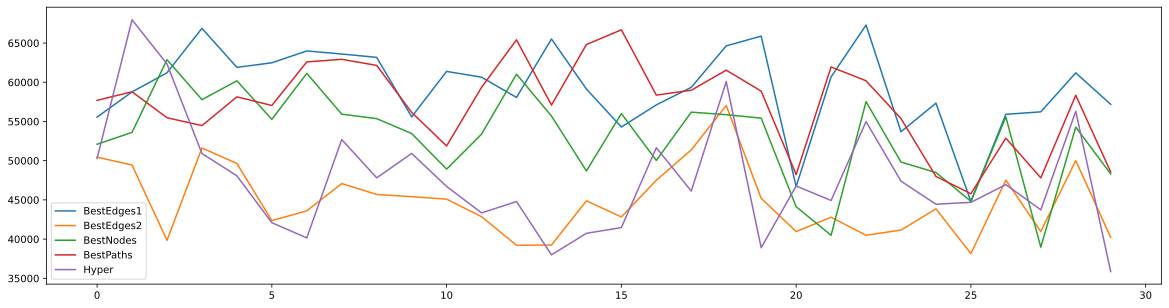

In [37]:
plt.figure(figsize=(20, 5))
for method in df["method"].unique():
    if method == "BestEdges3":
        continue
    obj = df[df["method"] == method]["objval"]
    plt.plot(list(range(len(obj))), obj, label=method)
plt.legend()
plt.show()

### 运行过程图

In [45]:
import pandas as pd
import numpy as np

In [46]:
df = pd.read_csv("../result/detail/r101_50.txt")
df

FileNotFoundError: [Errno 2] No such file or directory: '../result/detail/r101_50.txt'

In [39]:
f = open("../test_log.txt", 'r')
lines = f.readlines()
lines = [line.split("\n")[0] for line in lines]
array = [[info.split(":")[1] for info in line.split(', ')] for line in lines]
columns = [info.split(":")[0] for info in lines[0].split(', ')]
df = pd.DataFrame(data=array, columns=columns)
df[["reward", "objval", "time"]] = df[["reward", "objval", "time"]].astype('float64')
df

,t,reward,done,objval,heuristic,time
0,1,1.0,False,4915.9412,BestEdges2,251.295964
1,2,1.0,False,4286.2575,BestEdges2,851.491310
2,3,1.0,False,3969.2682,BestEdges2,1451.692317
3,4,1.0,False,3701.4950,BestEdges2,2051.910140
4,5,1.0,False,3260.0613,BestEdges2,2652.155111


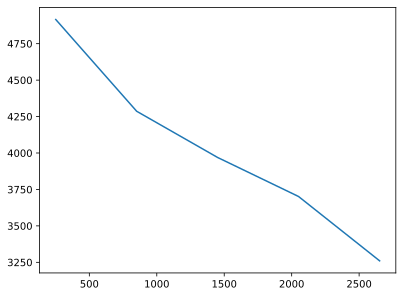

In [44]:
plt.plot(df['time'].astype(int), df['objval'])
plt.savefig("../test_tight.png", dpi=300, bbox_inches="tight")